In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.integrate import quad

In [2]:
np.random.seed(32)

### Data Load

In [4]:
### xdata
data = np.load('/Data/uquark.npz') 

In [5]:
xdata = data['x']
ydata = data['y']
print(xdata)
print(ydata)

[1.00000000e-04 1.15139540e-04 1.32571137e-04 1.52641797e-04
 1.75751062e-04 2.02358965e-04 2.32995181e-04 2.68269580e-04
 3.08884360e-04 3.55648031e-04 4.09491506e-04 4.71486636e-04
 5.42867544e-04 6.25055193e-04 7.19685673e-04 8.28642773e-04
 9.54095476e-04 1.09854114e-03 1.26485522e-03 1.45634848e-03
 1.67683294e-03 1.93069773e-03 2.22299648e-03 2.55954792e-03
 2.94705170e-03 3.39322177e-03 3.90693994e-03 4.49843267e-03
 5.17947468e-03 5.96362332e-03 6.86648845e-03 7.90604321e-03
 9.10298178e-03 1.04811313e-02 1.20679264e-02 1.38949549e-02
 1.59985872e-02 1.84206997e-02 2.12095089e-02 2.44205309e-02
 2.81176870e-02 3.23745754e-02 3.72759372e-02 4.29193426e-02
 4.94171336e-02 5.68986603e-02 6.55128557e-02 7.54312006e-02
 8.68511374e-02 1.00000000e-01 1.00000000e-01 1.16326531e-01
 1.32653061e-01 1.48979592e-01 1.65306122e-01 1.81632653e-01
 1.97959184e-01 2.14285714e-01 2.30612245e-01 2.46938776e-01
 2.63265306e-01 2.79591837e-01 2.95918367e-01 3.12244898e-01
 3.28571429e-01 3.448979

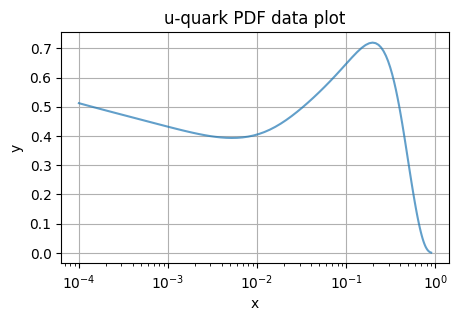

In [6]:
plt.figure(figsize=(5, 3))
plt.plot(xdata, ydata, alpha = 0.7)
plt.xscale('log')

plt.xlabel('x')
plt.ylabel('y')
plt.title('u-quark PDF data plot')
plt.grid(True)
plt.show()

### PDF Ansatz Model

In [8]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(params, xdata, num_qubits, num_layers):
    
    idx = 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            qml.RY(params[idx], wires = i)
            qml.RZ(params[idx+1]*xdata, wires = i, id= 'Data Upload')
            qml.RZ(params[idx+2], wires = i)
            qml.RY(params[idx+3], wires = i)
            qml.RZ(params[idx+4], wires = i)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CRZ(params[idx],[q, q+1])
                idx += 1
    
            if num_qubits > 2:
                qml.CRZ(params[idx], [num_qubits-1, 0])
                idx += 1

    for i in range(num_qubits):
        qml.RY(params[-1-i], wires = i)
    
    obs = qml.PauliZ(0)
    if num_qubits > 1:
        for i in range(num_qubits-1):
            obs @= qml.PauliZ(i+1)

    return qml.expval(obs)

In [9]:
num_layers = 1
num_qubits = 2
params = np.random.uniform(size = num_qubits*(5*num_layers + num_layers + 1) +num_qubits, requires_grad = True)

print(VQC_Model(params, 1, num_qubits, num_layers))
print(qml.draw(VQC_Model)(params, 1, num_qubits, num_layers))

-0.06406871231555614
0: ──RY(0.86)──RZ(0.37,"Data Upload")──RZ(0.56)──RY(0.96)──RZ(0.74)─╭●─────────RY(0.70)─┤ ╭<Z@Z>
1: ──RY(0.82)──RZ(0.10,"Data Upload")──RZ(0.93)──RY(0.61)──RZ(0.60)─╰RZ(0.09)──RY(0.55)─┤ ╰<Z@Z>


### Cost function

In [12]:
def cost_function(params, xdata, num_qubits, num_layers, y):
    loss = 0.0

    for i in range(len(xdata)):
        prediction = VQC_Model(params, xdata[i], num_qubits, num_layers)
        loss += (prediction - y[i])**2

    return loss / len(xdata)

### Model Running

In [14]:
def model_running(params, x, num_qubits, num_layers):
    
    exp_values = []

    for i in range(len(x)):
        expval = VQC_Model(params, x[i], num_qubits, num_layers)
        exp_values.append(expval)
        
    return np.array(exp_values)

In [16]:
def iterate_minibatches(inputs, targets, batch_size):
    
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Utility

In [15]:
def accuracy(ypred, ydata):

    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
    
    return score/len(ydata)

-----

In [17]:
train_data, test_data, train_target, test_target = train_test_split(xdata, ydata, test_size=0.2, random_state=32)
train_target = train_target.reshape(-1)
test_target = test_target.reshape(-1)

[3.90693994e-03 3.08884360e-04 2.68269580e-04 5.42867544e-04
 2.46938776e-01 8.02040816e-01 9.10298178e-03 2.81176870e-02
 1.15139540e-04 8.28642773e-04 7.69387755e-01 1.93069773e-03
 2.79591837e-01 1.00000000e-04 7.90604321e-03 5.08163265e-01
 3.77551020e-01 3.39322177e-03 7.19685673e-04 1.48979592e-01
 9.54095476e-04 1.00000000e-01 1.09854114e-03 1.26485522e-03
 1.67683294e-03 5.17947468e-03 8.18367347e-01 4.26530612e-01
 3.23745754e-02 6.38775510e-01 2.63265306e-01 1.97959184e-01
 8.83673469e-01 5.40816327e-01 7.85714286e-01 1.16326531e-01
 3.93877551e-01 7.54312006e-02 6.87755102e-01 5.68986603e-02
 5.24489796e-01 6.22448980e-01 5.73469388e-01 1.84206997e-02
 5.57142857e-01 6.86648845e-03 4.75510204e-01 2.32995181e-04
 4.59183673e-01 3.28571429e-01 1.32653061e-01 5.96362332e-03
 4.91836735e-01 8.34693878e-01 9.00000000e-01 2.12095089e-02
 4.10204082e-01 2.14285714e-01 1.00000000e-01 4.09491506e-04
 3.72759372e-02 2.94705170e-03 1.38949549e-02 1.20679264e-02
 3.44897959e-01 7.530612

In [ ]:
# Trainnig option settings
num_layers = 4
num_qubits = 1
epochs = 100
batch_size = 50
lr = 0.03

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
params = np.random.uniform(size = num_layers * 5 + num_qubits, requires_grad = True)

In [23]:
### Evaluating the qNN
# Running the model with test data
pred_train = model_running(params, train_data, num_qubits, num_layers)
score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(params, test_data, num_qubits, num_layers)

score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(params, test_data,num_qubits, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        params, _, _, _, _ = opt.step(cost_function, params, Xbatch, num_qubits, num_layers, ybatch)

    pred_train = model_running(params, train_data, num_qubits, num_layers)
    score_train = accuracy(pred_train, train_target)
    loss = cost_function(params, train_data,num_qubits, num_layers, train_target)

    pred_test = model_running(params, test_data, num_qubits, num_layers)
    score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)

Epoch:  0 | Cost: 0.221812 | Train accuracy: 0.062500 | Test Accuracy: 0.050000
Epoch:  1 | Loss: 0.126165 | Train accuracy: 0.212500 | Test accuracy: 0.300000
Epoch:  2 | Loss: 0.052978 | Train accuracy: 0.537500 | Test accuracy: 0.550000
Epoch:  3 | Loss: 0.055847 | Train accuracy: 0.062500 | Test accuracy: 0.000000
Epoch:  4 | Loss: 0.087108 | Train accuracy: 0.037500 | Test accuracy: 0.050000
Epoch:  5 | Loss: 0.080893 | Train accuracy: 0.037500 | Test accuracy: 0.100000
Epoch:  6 | Loss: 0.050661 | Train accuracy: 0.050000 | Test accuracy: 0.050000
Epoch:  7 | Loss: 0.024522 | Train accuracy: 0.362500 | Test accuracy: 0.350000
Epoch:  8 | Loss: 0.016254 | Train accuracy: 0.487500 | Test accuracy: 0.450000
Epoch:  9 | Loss: 0.021947 | Train accuracy: 0.337500 | Test accuracy: 0.300000
Epoch: 10 | Loss: 0.029572 | Train accuracy: 0.262500 | Test accuracy: 0.350000
Epoch: 11 | Loss: 0.031386 | Train accuracy: 0.250000 | Test accuracy: 0.350000
Epoch: 12 | Loss: 0.027200 | Train accur

In [ ]:
print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))


plt.plot(loss_list, '.-',label = 'loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Training Processe Loss")

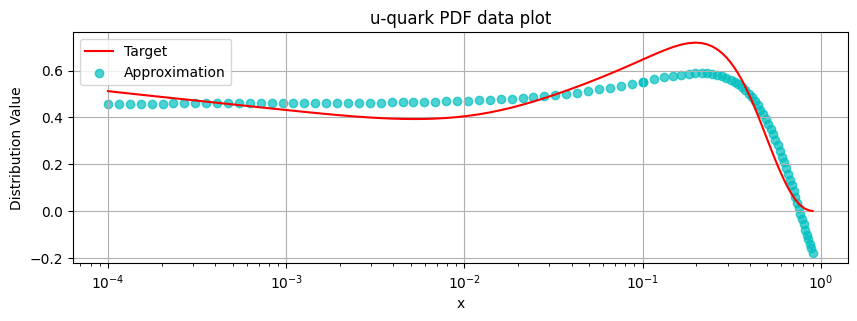

In [24]:
pred_test = model_running(params, xdata, num_qubits, num_layers)

fig, axis = plt.subplots(1, 1, figsize=(10, 3))
axis.plot(xdata, ydata, color = 'r', label = 'Target')
axis.scatter(xdata, pred_test, alpha = 0.7, color = 'c', label = 'Approximation')

axis.set_xscale('log')
axis.set_xlabel('x')
axis.set_ylabel('Distribution Value')
axis.set_title('u-quark PDF data plot')
axis.legend()
axis.grid(True)